In [2]:
# code to produce a "fake" spectrum from my model database (cascades after capture into specific state, 
# specified by key)

import numpy as np
import matplotlib.pyplot as plt
import os.path
from astropy.io import fits
import glob
from scipy import *

In [3]:
# import files to be used for spectrum components 

energygrid=np.arange(2400,3500,1)

#list0=glob.glob('./S01/data_corr/S01_nljjJ_06*') # add whatever files you'll need for your model
#list1=glob.glob('./S01/data_corr/S01_nljjJ_07*') 
#list2=glob.glob('./S01/data_corr/S01_nljjJ_08*')
listA=glob.glob('./S01/data_corr/S01_nljjJ_*')

#list3=glob.glob('./S02/data_corr/S02_nljjJ_07*')
#list4=glob.glob('./S02/data_corr/S02_nljjJ_06*')
#list5=glob.glob('./S02/data_corr/S02_nljjJ_04*')
#list6=glob.glob('./S02/data_corr/S02_nljjJ_05*')
listB=glob.glob('./S02/data_corr/S02_nljjJ_*')
                
#listA=list0+list1+list2
#listB=list3+list4+list5+list6
#print('listA= ',listA[0:3])

mydict={}

nums = [value[26:36] for value in listA]

for value in nums: # get list of files 
    filename='./S01/data_corr/S01_nljjJ_'+value+'.c.follow.fits'
    with fits.open(filename,memmap=False) as hdulist:
        mydict[value]=[hdulist[1].data.field("Energy"),hdulist[1].data.field("Strength")]
        del hdulist[1].data


nums = [value[26:36] for value in listB]

for value in nums: # get list of files 
    filename='./S02/data_corr/S02_nljjJ_'+value+'.c.follow.fits'
    with fits.open(filename,memmap=False) as hdulist:
        mydict[value]=[hdulist[1].data.field("Energy"),hdulist[1].data.field("Strength")]
        del hdulist[1].data
    #hdulist.close()


print(mydict.keys())

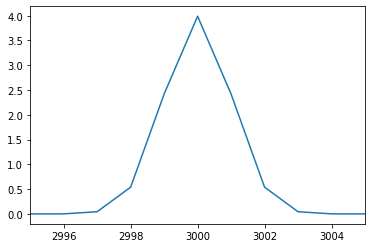

In [4]:
# make a gaussian from a given centroid

def make_gaussian(g_x, g_cen, g_amp, g_wid):
	#global g
	g=(g_amp/(np.sqrt(2*pi)*g_wid)) * np.exp(-(g_x-g_cen)**2 /(2*g_wid**2))
	return g

g=make_gaussian(energygrid,3000,10,1)
plt.plot(energygrid,g)
plt.xlim(2995,3005)
plt.show()

In [5]:
# grab cascade files you want to use to make fake spectrum 

def get_model_deets(key):
	key=str(key)
	if len(key)<10:
		key='0'+key
	en_st_array=mydict.get(key)
	energy=en_st_array[0]
	strength=en_st_array[1]
	#both=column_stack((energy, strength))
	#i=where(energy>0) # THIS SECTION TOOK AWAY ALL MY NEGATIVE VALUES FOR TWO-PHOTON TRANSITIONS
	k=np.where(energy>2400) 
	j=np.where(energy<3500)
	i=np.intersect1d(k,j)
	new_energy=energy[i]
	new_strength=strength[i]
	
	modeldeets=np.column_stack((new_energy,new_strength)) # so here I have made a new 2D array with columns being energy and strength, for the lines in the band I care about, from each Maurice file I call.
	#print 'modeldeets are: '
	#print modeldeets
	return modeldeets

In [6]:
# now make an individual spectrum from one particular cascade file 

def ind_cx_model(m_egrid, m_sig, m_norm, key):
    #print 'key in ind_cx_model= '+str(key)
    linelist=get_model_deets(key)
    #print linelist
    #global shape
    shape=np.zeros(len(m_egrid))
    
    for i in np.arange(len(linelist)): 
        cen=linelist[i,0]
        amp=linelist[i,1]*m_norm
        g=make_gaussian(m_egrid,cen,amp,m_sig)
        shape=np.add(shape,g)

    return shape


[12, 33, 56, 1, 80, 87, 11, 51, 64, 86]


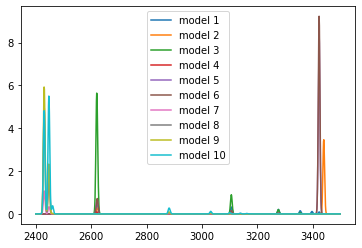

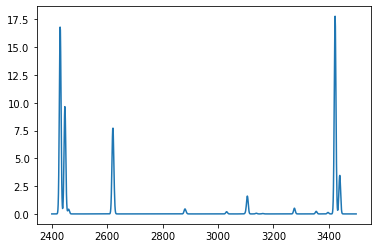

In [7]:
# now add up multiple spectra to make one composite one. Let's just start with H-like lines...

#weight1=0.85 
modweights = []
# Set a length of the list to 10
for i in range(0, 10):
    # any random numbers from 0 to 100
    modweights.append(random.randint(0, 100))
print(modweights)    
    
model1=ind_cx_model(energygrid, 3.0, modweights[0], 800000001)
model2=ind_cx_model(energygrid, 3.0, modweights[1], 801000003)
model3=ind_cx_model(energygrid, 3.0, modweights[2], 803000005) # degenerate with below 8f5/2
model4=ind_cx_model(energygrid, 3.0, modweights[3], 903000005) # degenerate with above 9f5/2
model5=ind_cx_model(energygrid, 3.0, modweights[4], 701000001) # degernate with below 7p1/2
model6=ind_cx_model(energygrid, 3.0, modweights[5], 701000003) # degenerate with above 7p3/2
model7=ind_cx_model(energygrid, 3.0, modweights[6], 700010102) # He-like, degen w below 7s1/2 J=1
model8=ind_cx_model(energygrid, 3.0, modweights[7], 800010102) # He-like, degen w above 8s1/2 J=1
model9=ind_cx_model(energygrid, 3.0, modweights[8], 802010002) # He-like, degen w below 8d 3/2 J=1
model10=ind_cx_model(energygrid, 3.0, modweights[9], 802010004) # He-like, degen w above 8d 3/2 J=2

plt.plot(energygrid,model1,label='model 1')
plt.plot(energygrid,model2,label='model 2')
plt.plot(energygrid,model3,label='model 3')
plt.plot(energygrid,model4,label='model 4')
plt.plot(energygrid,model5,label='model 5')
plt.plot(energygrid,model6,label='model 6')
plt.plot(energygrid,model7,label='model 7')
plt.plot(energygrid,model8,label='model 8')
plt.plot(energygrid,model9,label='model 9')
plt.plot(energygrid,model10,label='model 10')
plt.legend()
plt.show()

final=model1+model2+model3+model4+model5+model6+model7+model8+model9+model10
plt.plot(energygrid,final)
plt.show()

In [8]:
fakespec_x=np.savetxt('fakespec_x2.txt',energygrid)
fakespec_y=np.savetxt('fakespec_y2.txt',final)